# Random Forest
In this notebook, we fit a RF to the regression problem of predicting mean activity based on non-wearable features taken from the UK biobank. 

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [2]:
%cd ..
from accel.read_data import prep_data
from accel.constants import DATA_DIR, DEMO, PHYSICAL

/cdthome/xqe353


## Data prep

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data("/cdtshared/wearables/students/group5/eliminated-missing-participants.csv",
                                                                        [PHYSICAL],
                                                                        normalise = True,
                                                                        one_hot = True)

In [4]:
print(X_train.shape)
X_train.head()

(60829, 10)


,Above moderate/vigorous recommendation | Instance 0,Body mass index (BMI) | Instance 0,MET minutes per week for walking | Instance 0,MET minutes per week for vigorous activity | Instance 0,IPAQ activity group | Instance 0,Above moderate/vigorous/walking recommendation | Instance 0,Summed days activity | Instance 0,MET minutes per week for moderate activity | Instance 0,Duration of walks | Instance 0,Frequency of stair climbing in last 4 weeks | Instance 0
17537,0.905855,-0.106426,0.057918,-0.545487,1.065866,0.459706,0.918630,3.579646,-0.166814,-0.218657
77203,-1.103929,0.027618,-0.637437,-0.508467,-0.311621,0.459706,-0.358617,-0.294569,-0.534969,-0.218657
83172,0.905855,1.193208,-0.637437,1.601703,1.065866,0.459706,0.918630,0.273649,-0.534969,0.570276
74938,-1.103929,-0.436555,-0.960858,-0.175282,-0.311621,-2.175447,-0.145743,-0.346225,0.000000,0.000000
29263,0.905855,-0.448076,3.114248,8.709642,1.065866,0.459706,2.195878,3.579646,5.355510,-0.218657


# Random Forest

In [5]:
from time import time
from sklearn.ensemble import RandomForestRegressor
from accel.training import model_tune, score

## Timing
Timing how long it takes to fit an SVM to different sizes of data. Keep in mind, there are 69567 training observations.

In [6]:
Ns = np.arange(100,10001,1000)
Ns

array([ 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100])

In [7]:
reps = 5
times = np.zeros((reps,len(Ns)))

for r in range(reps):
    print("Rep",r, "Size:", end="")
    for i in range(len(Ns)):
        print(Ns[i],end=", ")
        N = Ns[i]
        clf = RandomForestRegressor() # default RF
        start = time()
        clf.fit(X_train[:N], y_train[:N ]) #train model and time
        times[r,i] = time() - start
    print()

Rep 0 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 1 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 2 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 3 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 4 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 


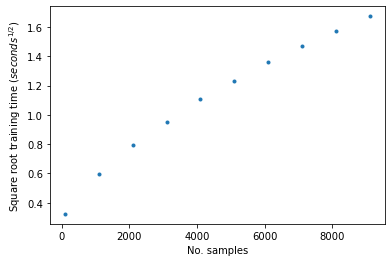

In [8]:
plt.plot(Ns, np.sqrt(np.mean(times,axis=0)), ".")
plt.xlabel("No. samples")
plt.ylabel("Square root training time ($seconds^{1/2}$)")
plt.show()

In [9]:
root_mean_times = np.sqrt(np.mean(times,axis=0))
m = root_mean_times[-1] / Ns[-1]
m

0.00018391741284778295

In [10]:
# Time it takes for 9000 samples
(m * 9100)

1.673648456914825

In [11]:
N_train = X_train.shape[0]
pred_secs = (m * N_train)**2 #answer in seconds
print("Predicted training time in minutes", pred_secs / 60) # answer in minutes

Predicted training time in minutes 2.086007193325616


In [12]:
# fitting the classifier
clf = RandomForestRegressor()
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

20.498677492141724

How good is the out the box model?

In [13]:
from accel.training import score

In [14]:
y_pred = clf.predict(X_val)

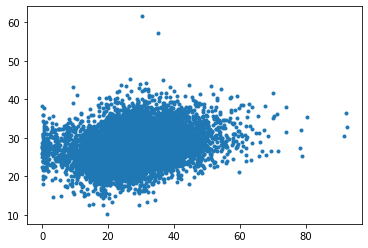

In [15]:
plt.plot(y_val,y_pred, ".")

In [16]:
score(y_val, y_pred)

MSE is:  80.7444907668295
R2 is:  0.04128308888409027
Explained variance is: 0.041317879510728184


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)

# Hyper-parameter tuning
We perform hyper-parameter tuning on the linear SVM since it is less time-consuming to fit

In [17]:
from accel.training import model_tune

In [18]:
y_train.std()

9.311881251340733

In [19]:
# define lists of params interested in

# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Get the optimal parameters
model_tune(RandomForestRegressor(), 
                 params, X_train, y_train, X_val, y_val, 20)

Best parameters: <br>
**bootstrap**:True <br>
**max_depth**: 10 <br>
**max_features**: 'sqrt' <br>
**min_samples_leaf**: 10 <br>
**min_samples_split**: 5 <br>
**n_estimators**: 150 <br>

In [20]:
clf = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf = 10, min_samples_split = 5, n_estimators = 150)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=5, n_estimators=150)

MSE is:  75.33149061383853
R2 is:  0.10555415849218985
Explained variance is: 0.10568702882096226


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)

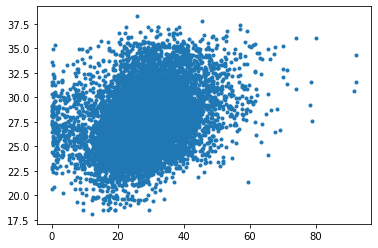

In [21]:
y_pred = clf.predict(X_val)
plt.plot(y_val,y_pred, ".")
score(y_val, y_pred)

## Full Model

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data("/cdtshared/wearables/students/group5/eliminated-missing-participants.csv",
                                                                        normalise = True,
                                                                        one_hot = True)

In [23]:
clf = RandomForestRegressor()
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

202.09736251831055

In [24]:
model_tune(RandomForestRegressor(), 
                 params, X_train, y_train, X_val, y_val, 20)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=RandomForestRegressor(), n_iter=20, refit=False,
              search_spaces={'bootstrap': [True, False],
                             'max_depth': [10, 50, None],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [2, 4, 10],
                             'min_samples_split': [5, 10],
                             'n_estimators': [10, 25, 50, 100, 150]},
              verbose=1)

Best parameters: <br>
**bootstrap**:False <br>
**max_depth**: None <br>
**max_features**: 'sqrt' <br>
**min_samples_leaf**: 2 <br>
**min_samples_split**: 5 <br>
**n_estimators**: 150 <br>

In [25]:
model = RandomForestRegressor(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 150)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150)

MSE is:  70.25356098639082
R2 is:  0.1658467798346055
Explained variance is: 0.1659125538813111


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)

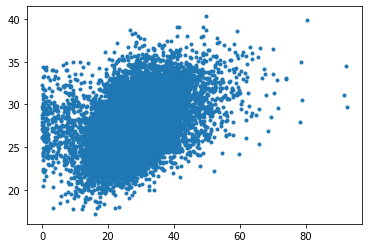

In [26]:
y_pred = model.predict(X_val)
plt.plot(y_val,y_pred, ".")
score(y_val, y_pred)

# Feature Importance

In [27]:
# organise features by importance
sorted_tuples = list(zip(model.feature_importances_, X_train.columns))
sorted_tuples.sort(key=lambda tup: tup[0])
importance, feature = zip(*sorted_tuples)

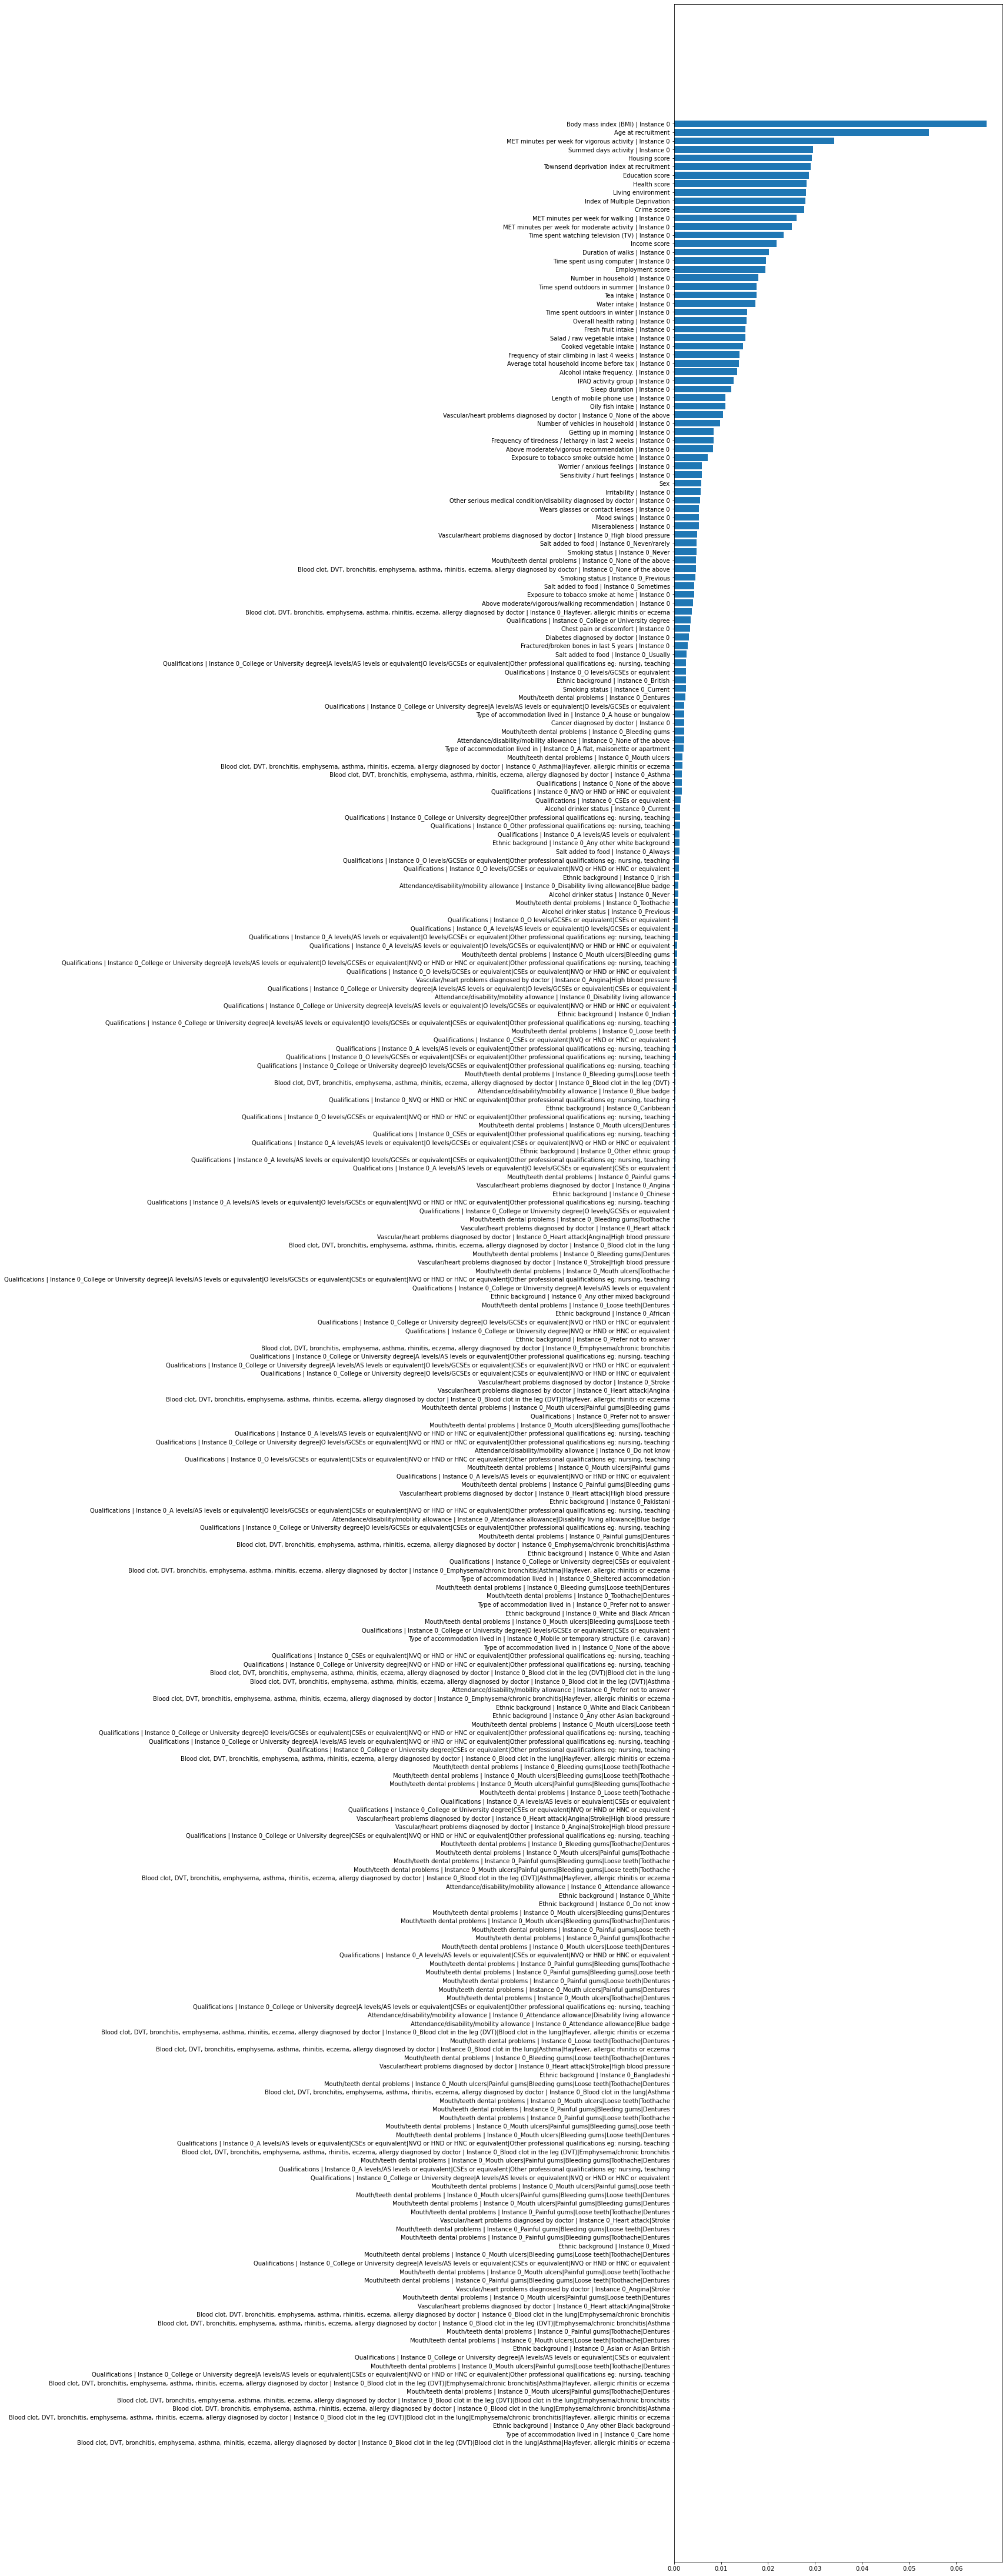

In [28]:
plt.figure(figsize=(10,80))
plt.barh(np.arange(len(importance)), importance, tick_label=feature)
plt.show()

# Test

In [29]:
X = np.vstack((X_train, X_val))
y = np.concatenate([y_train, y_val])

In [30]:
model = RandomForestRegressor(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 150)
model.fit(X, y)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150)

In [31]:
# Get the test set performance
score(y_test, model.predict(X_test))

/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


MSE is:  72.38660325024168
R2 is:  0.15738126089369964
Explained variance is: 0.15738954555290574


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)